In [43]:
import collections
import random
import copy

from matplotlib import pylab as plt
import torch
from torch import nn
from torch import optim

from gridworld.Gridworld import Gridworld

In [45]:
EPOCHS = 250
MEM_SIZE = 1000
BATCH_SIZE = 200
MAX_MOVES = 50
EPSILON = 0.2
GAMMA = 0.9
EPSILON = 0.3

In [46]:
h = 0
sync_freq = 500
j = 0
losses = []
replay = collections.deque(maxlen=MEM_SIZE)

In [47]:
n_pixels = 64
hidden_1 = 150
hidden_2 = 100
n_actions = 4

regular_model = nn.Sequential(
    nn.Linear(n_pixels, hidden_1),
    nn.ReLU(),
    nn.Linear(hidden_1, hidden_2),
    nn.ReLU(),
    nn.Linear(hidden_2, n_actions)
)

target_model = copy.deepcopy(regular_model)
target_model.load_state_dict(regular_model.state_dict())

<All keys matched successfully>

In [48]:
loss_func = nn.MSELoss()
learning_rate = 1e-3
optimizier = optim.Adam(regular_model.parameters(), lr=learning_rate)

In [49]:
action_set = {
    0: 'u',
    1: 'd',
    2: 'l',
    3: 'r'
}

In [50]:
for i in range(EPOCHS):
    game = Gridworld(size=4, mode='random')
    
    noise = torch.randn(1, 64) / 100.
    state = game.board.render_np().reshape(1, 64)
    state = torch.from_numpy(state) + noise
    
    is_in_progress = True
    move = 0
    
    while is_in_progress:
        j += 1
        move += 1
        predicted_reward = regular_model(state)
        
        if (random.random() < EPSILON):
            action_idx = torch.randint(0, 4, (1, )).item()
        else:
            action_idx = torch.argmax(predicted_reward).item()
        
        action = action_set[action_idx]
        game.makeMove(action)
        
        new_noise = torch.randn(1, 64) / 100.
        new_state = game.board.render_np().reshape(1, 64)
        new_state = torch.from_numpy(new_state) + new_noise
        
        reward = game.reward()
        
        is_done = True if reward > 0 else False
        exp = (state, action_idx, reward, new_state, is_done)
        replay.append(exp)
        state = new_state
        
        if len(replay) > BATCH_SIZE:
            mini_batch = random.sample(replay, BATCH_SIZE)
            
            state_batch = torch.cat([state for (state, action_idx, reward, new_state, is_done) in mini_batch])
            action_batch = torch.tensor([action_idx for (state, action_idx, reward, new_state, is_done) in mini_batch])
            reward_batch = torch.tensor([reward for (state, action_idx, reward, new_state, is_done) in mini_batch])
            new_state_batch = torch.cat([new_state for (state, action_idx, reward, new_state, is_done) in mini_batch])
            is_done_batch = torch.tensor([is_done for (state, action_idx, reward, new_state, is_done) in mini_batch])
            
            regular_replay_predicted_reward = regular_model(state_batch)
            
            with torch.no_grad():
                target_replay_predicted_reward = target_model(state_batch)
            
            target_reward = reward_batch + GAMMA * ((1-is_done_batch.int()) * torch.max(target_replay_predicted_reward, dim=-1)[0])
            current_predicted_reward = regular_replay_predicted_reward.gather(dim=-1, index=action_batch.long().unsqueeze(dim=-1)).squeeze()
            
            loss = loss_func(current_predicted_reward, target_reward)
            losses.append(loss.item())
            
            optimizier.zero_grad()
            loss.backward()
            optimizier.step()
            
            if j % sync_freq == 0:
                target_model.load_state_dict(regular_model.state_dict())
        if reward != -1 or move > MAX_MOVES:
            is_in_progress = False
            move = 0

In [51]:
torch.randint(0, 4, (1, )).item()

0

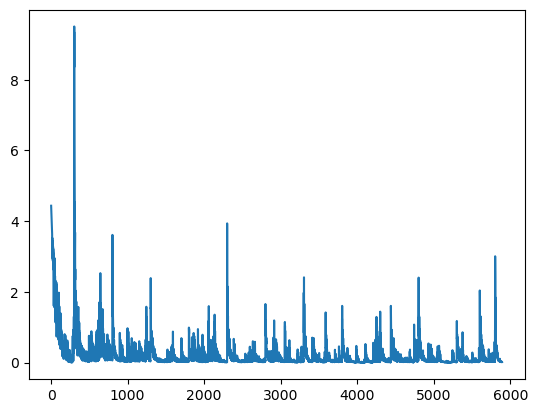

In [52]:
plt.plot(losses)
plt.show()